In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import unicodedata
from scipy import integrate
from scipy import interpolate
import math
from itertools import compress

# Figure 1

Text(0, 0.5, 'P(θ)')

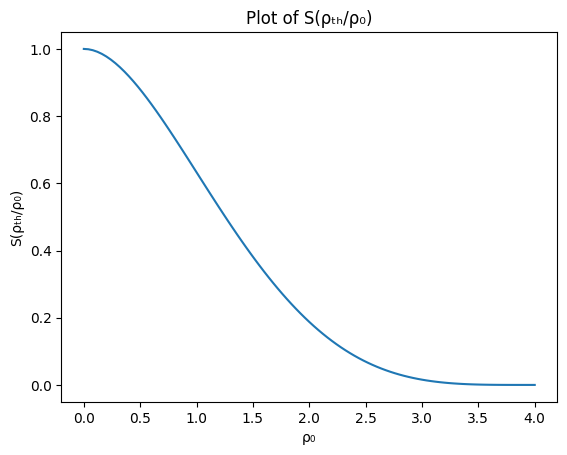

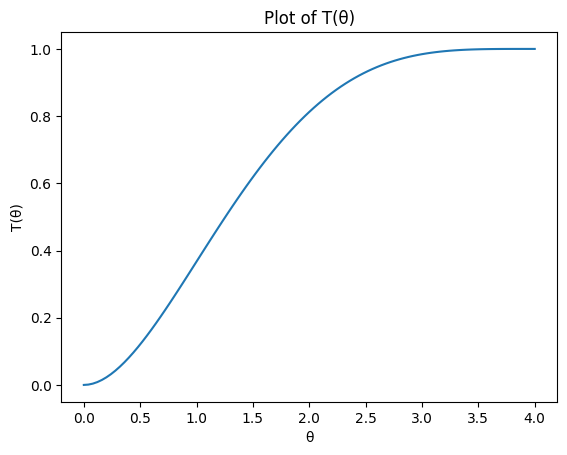

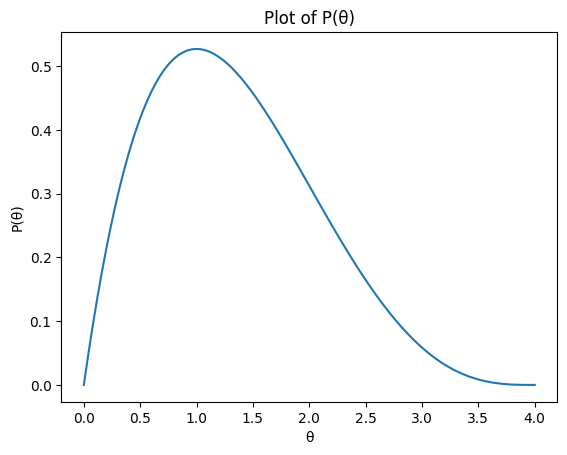

In [ ]:

#define symbols for plot names
theta = unicodedata.lookup('GREEK SMALL LETTER THETA')
rho = unicodedata.lookup('GREEK SMALL LETTER RHO')
sub_0 = '\u2080'
sub_h = '\u2095'
sub_t = '\u209C'

#Define P(theta)
def P_pdf(x):
  y = 5*x/(256)*(4-x)**3
  y[x>4] = 0
  return y

#Define T(theta)
def calc_int_pdf(theta):
  Pint = 5/256*theta**2*(-theta**3/5+3*theta**2-16*theta+32)
  Pint[theta>4] = 1  #1 = T(4) = 5/256*4**2*(-4**3/5+3*4**2-16*4+32)
  return Pint

#Define S(rho)
def calc_S(x):
  y = calc_int_pdf(4) - calc_int_pdf(x)
  return y

#Calculate functions for 0 < theta < 4
theta_vals = np.linspace(0.,4.,101)
pdf = P_pdf(theta_vals)
int_pdf = calc_int_pdf(theta_vals)
#fos = calc_S(theta_vals)
fos = 1-calc_int_pdf(theta_vals)

#Plot figures
plt.figure(1)
plt.plot(theta_vals,fos)
plt.title(f"Plot of S({rho}{sub_t}{sub_h}/{rho}{sub_0})")
plt.xlabel(f"{rho}{sub_0}")
plt.ylabel(f"S({rho}{sub_t}{sub_h}/{rho}{sub_0})")

plt.figure(2)
plt.plot(theta_vals,int_pdf)
plt.title(f"Plot of T({theta})")
plt.xlabel(f"{theta}")
plt.ylabel(f"T({theta})")

plt.figure(3)
plt.plot(theta_vals,pdf)
plt.title(f"Plot of P({theta})")
plt.xlabel(f"{theta}")
plt.ylabel(f"P({theta})")


# Figure 2

# 1.1 PEAK Mass Model g

In [ ]:
#Define f(m)
def f_func(m,deltam):
  f = np.exp(deltam/m + deltam/(m-deltam))
  f_inv = 1/(f+1)
  return f_inv

#Define S(m)
def S_func(mlist,mmin,dm):
  case1 = np.where(mlist<=mmin)
  mv1 = mlist.copy()
  update = np.zeros(len(case1[0]))
  mv1[case1] = update

  case2 = np.where((mmin < mlist) & (mlist < mmin + dm))
  mv2 = mv1.copy()
  update2 = (f_func(mv2[case2]-mmin,dm))
  mv2[case2] = update2

  case3 = np.where(mlist>=mmin+dm)
  mv3 = mv2.copy()
  update3 = 1*np.ones(len(case3[0]))
  mv3[case3] = update3
  return mv3

def step_function(mlist,mmin,dm):
  mv = np.zeros(mlist.shape)
  mv[mlist>(mmin+dm/2)] = 1
  return mv

#Define G(m)
def calc_gaussian(m,mu,sigma):
  norm = 1/(sigma*np.sqrt(2*np.pi))
  gauss = norm*np.exp(-1*(m-mu)**2/(2*sigma**2))
  return gauss

#Define B(m)
def power_law(m,alph,mmin,mmax):
  mv = np.zeros(len(m))
  mv[m<mmax] = m[m<mmax]**(-1*alph)
  return mv

#Define

#Combine it all into f/g
def g_pdf_peak_norm(m,lamb,alph,mmin,dm,mmax,mu_m,sigm_m): #Use for normalisation factor
  part1 = power_law(m,alph,mmin,mmax)*S_func(m,mmin,dm)
  part2 = calc_gaussian(m,mu_m,sigm_m)*S_func(m,mmin,dm)
  #Normalize each part individually
  dm1 = m[1]-m[0]
  diff = np.abs(np.diff(m))
  I1 = np.sum(part1*dm1)
  norm1 = 1/I1
  I2 = np.sum(part2*dm1)
  norm2 = 1/I2
  part1 = (1-lamb)*part1/I1
  part2 = lamb*part2/I2
  #Normalize the entire function
  I3 = np.sum((part1[:-1]+part2[:-1])*diff)
  norm3 = 1/I3
  return norm1,norm2,norm3

def g_pdf_peak(m,lamb,alph,mmin,dm,mmax,mu_m,sigm_m,norm1,norm2): #Use for unnormalised values

  part1 = power_law(m,alph,mmin,mmax)*S_func(m,mmin,dm)
  part2 = calc_gaussian(m,mu_m,sigm_m)*S_func(m,mmin,dm)
  #Normalize each part individually
  part1 = (1-lamb)*part1*norm1
  part2 = lamb*part2*norm2
  #Normalize the entire function

  m_pdf = part1+part2

  return m_pdf


# 1.1.1 Test S and G

Text(0.5, 0, 'm1')

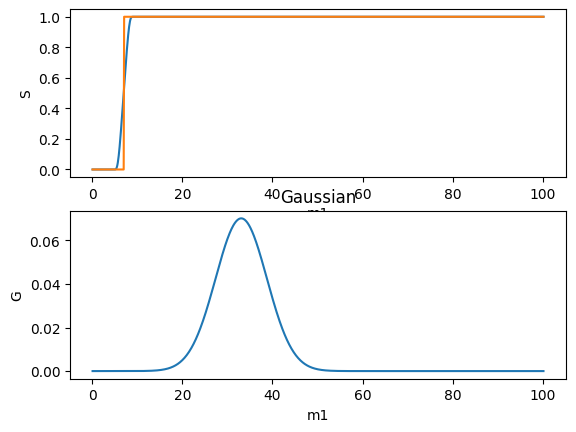

In [ ]:
test_m1 = np.linspace(0.1,100.1,1001)
test_m2 = np.linspace(0.1,100.1,1001)
mmin = 4.59
dm = 4.82
mu_m = 33.07
sigm_m = 5.69

testS = S_func(test_m1,mmin,dm)
testS2 = step_function(test_m1,mmin,dm)
testG = calc_gaussian(test_m2,mu_m,sigm_m)

plt.subplot(211)
plt.plot(test_m1,testS)
plt.plot(test_m1,testS2)
plt.ylabel('S')
plt.xlabel('m1')

plt.subplot(212)
plt.title('Gaussian')
plt.plot(test_m2,testG)
plt.ylabel('G')
plt.xlabel('m1')



# 1.1.2 Broken Power-Law Mass Model g

In [ ]:
def integrand2(x,alpha,mbreak):
  y = (x/mbreak)**(-alpha)
  return y

def g_pdf_broken_norm(m,alpha1,alpha2,mmin,mmax,dm,b): #Use this for normalisation
  mbreak = mmin + b*(mmax - mmin)
  dm1 = m[1]-m[0]

  case1 = np.where((mmin < m) & (m < mbreak))
  mv1 = m.copy()
  update1 = ((mv1[case1]/mbreak)**(-1*alpha1))*S_func(mv1[case1],mmin,dm)
  I1 = np.sum(update1*dm1) #normalise the first part
  mv1[case1] = update1

  case2 = np.where((mbreak < m) & (m < mmax))
  mv2 = mv1.copy()
  update2 = ((mv2[case2]/mbreak)**(-1*alpha2))*S_func(mv2[case2],mmin,dm)
  I2 = np.sum(update2*dm1) #normalise the second part
  mv2[case2] = update2

  case3 = np.where((m < mmin))
  mv3 = mv2.copy()
  update3 = np.zeros(len(case3[0]))
  mv3[case3] = update3

  case4 = np.where((m > mmax))
  mv4 = mv3.copy()
  update4 = np.zeros(len(case4[0]))
  mv4[case4] = update4

  I3 = I1+I2 #normalise the entire function
  norm =  1/I3
  return norm

def g_pdf_broken(m,alpha1,alpha2,mmin,mmax,dm,b): #Use this for unnormalised values
  mbreak = mmin + b*(mmax - mmin)

  case1 = np.where((mmin < m) & (m < mbreak))
  mv1 = m.copy()
  update1 = ((mv1[case1]/mbreak)**(-1*alpha1))*S_func(mv1[case1],mmin,dm)
  mv1[case1] = update1

  case2 = np.where((mbreak < m) & (m < mmax))
  mv2 = mv1.copy()
  update2 = ((mv2[case2]/mbreak)**(-1*alpha2))*S_func(mv2[case2],mmin,dm)
  mv2[case2] = update2

  case3 = np.where((m < mmin))
  mv3 = mv2.copy()
  update3 = np.zeros(len(case3[0]))
  mv3[case3] = update3

  case4 = np.where((m > mmax))
  mv4 = mv3.copy()
  update4 = np.zeros(len(case4[0]))
  mv4[case4] = update4

  return mv4


#1.1.3 Define f(q)

In [ ]:
def f_pdf(q,m1,beta,mmin,dm):
  mv1 = m1*(q**(beta))*S_func(q*m1,mmin,dm)
  return mv1

In [ ]:
def f_pdf_norm(beta,m1,mmin,dm):
  ylist = [] #normalisation list

  normlist = np.linspace(0.1,m1,1000) #arrays to integrate from 0 tot m1
  normlist = np.transpose(normlist) #Change the arrays to the right shape
  dm1 = normlist[0:,1]-normlist[0:,0] #integral step size for each integral
  y = m1*(normlist**beta)*S_func(normlist,mmin,dm) #value of function for each value
  yval = 1/(np.sum(y,axis = 1)*dm1) #norm factor based on integral value for each m1
  ylist.append(yval) #add to normalisation list
  ylist = np.array(ylist)
  return ylist

In [ ]:
def norm_secondary_peak(m1):

    beta = 1.40

    mm2 = np.linspace(1.e-3,m1,1001)
    mm1 = np.tile(m1, (mm2.shape[0],1))
    #SSP = (mm2/mm1)**beta / mm1 * S_func(mlist=mm2, mmin=4.59, dm=4.82)
    SSP = (mm2/mm1)**beta * S_func(mlist=mm2, mmin=4.59, dm=4.82)
    #SSP = (mm2/mm1)**beta / mm1 * step_function(mlist=mm2, mmin=4.59, dm=4.82)

    P = np.sum( (SSP[1:]+SSP[:-1]) * np.absolute(np.diff(mm2, axis=0))/2. , axis=0)
    return P

<ipython-input-3-3ca3784daf5b>:3: RuntimeWarning: overflow encountered in exp
  f = np.exp(deltam/m + deltam/(m-deltam))


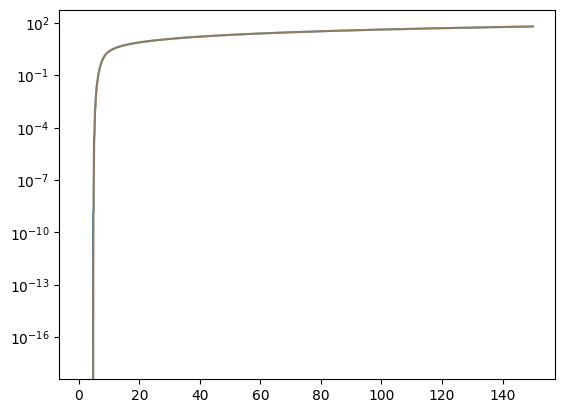

In [ ]:
m1 = np.linspace(1., 150., 501)
m2 = np.linspace(1., 150., 1001)
norm_secondary_peak_pdf = interpolate.interp1d(m1, norm_secondary_peak(m1), kind='linear')
norm_secondary_peak_pdf2 = norm_secondary_peak(m2)
plt.plot(m2,norm_secondary_peak_pdf(m2))
plt.plot(m2,norm_secondary_peak(m2),alpha=0.5)
plt.yscale('log')

<ipython-input-3-3ca3784daf5b>:3: RuntimeWarning: overflow encountered in exp
  f = np.exp(deltam/m + deltam/(m-deltam))


1.0348232222627263


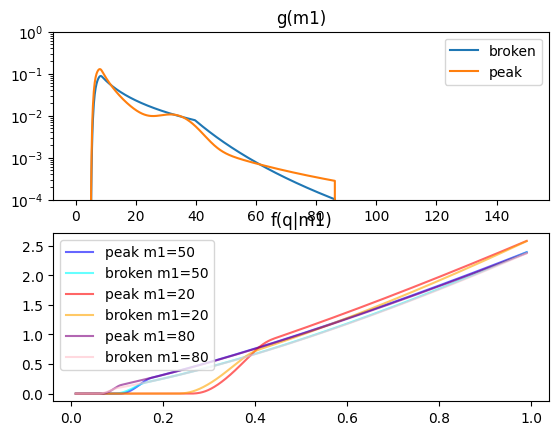

In [ ]:
#Peak model
lamb = 0.10
alph = 2.63
mmin = 4.59
dm = 4.82
mmax = 86.22
mu_m = 33.07
sigm_m = 5.69
beta = 1.26
#Broken model
alpha1 = 1.58
alpha2 = 5.59
mmin2 = 3.96
mmax2 = 87.14
beta2 = 1.40
dm2 = 4.83
b = 0.43

m1norm = np.linspace(0.1,100.1,101)
m1 = np.linspace(0.01,150.,1000)

gnorm = g_pdf_broken_norm(m1norm,alpha1,alpha2,mmin,mmax,dm,b)
g1 = g_pdf_broken(m1,alpha1,alpha2,mmin,mmax,dm,b)*gnorm

gnorm2 = g_pdf_peak_norm(m1norm,lamb,alph,mmin,dm,mmax,mu_m,sigm_m) #Normalisation for g(m1)
g2 = gnorm2[2]*g_pdf_peak(m1,lamb,alph,mmin,dm,mmax,mu_m,sigm_m,gnorm2[0],gnorm2[1]) #g(m1)

qlist = np.linspace(0.01,0.99,1000)
dq = qlist[1]-qlist[0]
m1q = 50
q1 = f_pdf(qlist,m1q,beta,mmin,dm)/norm_secondary_peak_pdf(m1q)
q2 = f_pdf(qlist,m1q,beta2,mmin2,dm2)/norm_secondary_peak_pdf(m1q)
q3 = f_pdf(qlist,20,beta,mmin,dm)/norm_secondary_peak_pdf(20)
q4 = f_pdf(qlist,20,beta2,mmin2,dm2)/norm_secondary_peak_pdf(20)
q5 = f_pdf(qlist,80,beta,mmin,dm)/norm_secondary_peak_pdf(80)
q6 = f_pdf(qlist,80,beta2,mmin2,dm2)/norm_secondary_peak_pdf(80)
#norm_secondary_peak_pdf(m1q) #peak model

plt.subplot(211)
plt.plot(m1,g1,label='broken')
plt.plot(m1,g2,label='peak')
plt.legend()
plt.yscale('log')
plt.ylim(1e-4,1)
plt.title('g(m1)')

plt.subplot(212)
plt.plot(qlist,q1,label = 'peak m1=50',color='blue',alpha=0.6)
print(np.sum((q1[1:]+q1[:-1])/2*dq))
plt.plot(qlist,q2,label='broken m1=50',color='cyan',alpha=0.6)
plt.plot(qlist,q3,label = 'peak m1=20',color='red',alpha=0.6)
plt.plot(qlist,q4,label='broken m1=20',color='orange',alpha=0.6)
plt.plot(qlist,q5,label = 'peak m1=80',color='purple',alpha=0.6)
plt.plot(qlist,q6,label='broken m1=80',color='pink',alpha=0.6)
plt.legend()
#plt.yscale('log')
#plt.ylim(1e-4,1)
plt.title('f(q|m1)')

dm1 = np.abs(np.diff(m1))
gdm1 = np.sum((g1[:-1]+g1[1:]/2*dm1))

# 1.2 Calculate x1(=m2) and dx1/dm

In [ ]:
#Define constants
def dx1dm_calc(m1,m_c):
  #Calculate functions
  a = (m_c**(5/3))/((2**(1/3))*(3**(2/3))*(m1**(3/2)))
  b = (9*m1**(5/2) + (81*(m1**5) - 12*(m_c**5))**(0.5))**(1/3)
  c = (9*m1**(5/2) - (81*(m1**5) - 12*(m_c**5))**(0.5))**(1/3)
  x1 = a*(b+c)
  #Calculate derivative values
  dadm = (5/3)*(m_c**(2/3))/((2**(1/3))*(3**(2/3))*(m1**(3/2)))
  dbdm = (1/3)*(b**(-2))*(-30*m_c**(4)*(81*m1**5-12*m_c**5)**(-1/2))
  dcdm = (1/3)*(c**(-2))*( 30*m_c**(4)*(81*m1**5-12*m_c**5)**(-1/2))
  #Calculate total derivative
  dx1dm = dadm*(b+c) + a*(dbdm+dcdm)
  return x1, dx1dm


# 1.2.1 Test G(m1) for both models

Text(0, 0.5, 'p(m1)')

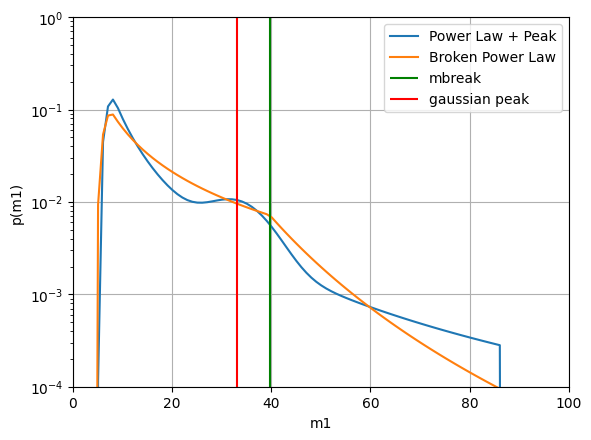

In [ ]:
#constant for peak model
lamb = 0.10
alph = 2.63
mmin = 4.59
dm = 4.82
mmax = 86.22
mu_m = 33.07
sigm_m = 5.69
#constants for broken model
alpha1 = 1.58
alpha2 = 5.59
mmin2 = 3.96
mmax2 = 87.14
dm2 = 4.83
b = 0.43
#calculate the pdf's
test_m1 = np.linspace(0.1,100.1,101)
dm1 = test_m1[1] - test_m1[0]

ynorm1 = g_pdf_peak_norm(test_m1,lamb,alph,mmin,dm,mmax,mu_m,sigm_m)
y_test_1 = ynorm1[2]*g_pdf_peak(test_m1,lamb,alph,mmin,dm,mmax,mu_m,sigm_m,ynorm1[0],ynorm1[1])
ynorm2 = g_pdf_broken_norm(test_m1,alpha1,alpha2,mmin2,mmax2,dm2,b)
y_test_2 = ynorm2*g_pdf_broken(test_m1,alpha1,alpha2,mmin2,mmax2,dm2,b)

#plot the pdf's
plt.plot(test_m1,y_test_1,label = 'Power Law + Peak')
plt.plot(test_m1,y_test_2, label = 'Broken Power Law')
plt.vlines(39.7274,10**-6,1,color = 'green',label = 'mbreak')
plt.vlines(mu_m,10**-6,1,color = 'red', label = 'gaussian peak')
plt.legend()
plt.yscale('log')
plt.ylim(10**-4,1)
plt.xlim(0,100)
plt.grid()
plt.xlabel('m1')
plt.ylabel('p(m1)')








# Testing the PDF functions

# 1.3 Define ϕ(M) for both models

#Define peak model

In [ ]:
def integrand_peak(m1,m_c,lamb,alph,beta,mmin,dm,mmax,mu_m,sigm_m):
  x1, dx1dm = dx1dm_calc(m1,m_c)
  qlist = x1/m1
  dx1 = np.abs(np.diff(x1))
  dq = np.abs(np.diff(qlist))
  m1norm = np.linspace(0.1,100.1,101)
  y2norm = g_pdf_peak_norm(m1norm,lamb,alph,mmin,dm,mmax,mu_m,sigm_m)
  #y1 = f_pdf_norm(beta,m1,mmin,dm)*f_pdf(x1,m1,beta,mmin,dm)
  y1 = f_pdf(qlist,m1,beta,mmin,dm)/norm_secondary_peak_pdf(m1)
  y2 = y2norm[2]*g_pdf_peak(m1,lamb,alph,mmin,dm,mmax,mu_m,sigm_m,y2norm[0],y2norm[1])
  ytot  = y1*y2*dx1dm
  return ytot

In [ ]:
def phi_peak(m_c_list,lamb,alph,beta,mmin,dm,mmax,mu_m,sigm_m,npts):
  phi_list = []
  for m_c in m_c_list:
    m1min = m_c*(2)**(1/5)+0.01
    m1max = mmax+5
    m1_list = np.linspace(m1min,m1max,npts)
    dm1 = m1_list[1]-m1_list[0]
    phi_integrand = integrand_peak(m1_list,m_c,lamb,alph,beta,mmin,dm,mmax,mu_m,sigm_m)
    phi_val = np.sum(phi_integrand*dm1)
    phi_list.append(phi_val)

  phi_list = np.array(phi_list)
  dm_c = np.abs(np.diff(m_c_list))
  I1 = np.sum(phi_list)*(m_c_list[1]-m_c_list[0])
  I2 = np.sum(phi_list[:-1]*dm_c)
  phi_list = 1/I2*phi_list
  return phi_list

#Define broken model

In [ ]:
def integrand_broken(m1,m_c,alpha1,alpha2,beta,mmin,mmax,dm,b):
  #Calculate m2 from m1 and Mc
  x1, dx1dm = dx1dm_calc(m1,m_c)
  dx1 = np.abs(np.diff(x1))
  m1norm = np.linspace(0.1,100.1,101)
  #Calculate q from m2 and m1
  qlist = x1/m1
  dq = np.abs(np.diff(qlist))
  #calculate f and normalise it
  #y1 = f_pdf_norm(beta,m1,mmin,dm)*f_pdf(x1,m1,beta,mmin,dm)
  y1 = f_pdf(qlist,m1,beta,mmin,dm)/norm_secondary_peak_pdf(m1)
  #calculate g and normalise it
  y2norm = g_pdf_broken_norm(m1norm,alpha1,alpha2,mmin,mmax,dm,b)
  y2 = g_pdf_broken(m1,alpha1,alpha2,mmin,mmax,dm,b)*y2norm
  #combine into final integrand
  ytot = y1*y2*dx1dm
  return ytot

In [ ]:
def phi_broken(m_c_list,alpha1,alpha2,beta,mmin,mmax,dm,b,npts):
  phi_list = []
  for m_c in m_c_list:
    m1min = m_c*(2)**(1/5)+0.01
    m1max = mmax+5
    m1_list = np.linspace(m1min,m1max,npts)
    phi_integrand = integrand_broken(m1_list,m_c,alpha1,alpha2,beta,mmin,mmax,dm,b)
    dm1 = m1_list[1]-m1_list[0]
    phi_val = np.sum(phi_integrand*dm1)
    phi_list.append(phi_val)

  phi_list = np.array(phi_list)
  dm_c = np.abs(np.diff(m_c_list))
  I2 = np.sum(phi_list[:-1]*dm_c)
  I1 = np.sum(phi_list*(m_c_list[1]-m_c_list[0]))

  phi_list = 1/I1*phi_list
  return phi_list


# 1.3 Test phi(M)

<ipython-input-3-3ca3784daf5b>:3: RuntimeWarning: overflow encountered in exp
  f = np.exp(deltam/m + deltam/(m-deltam))


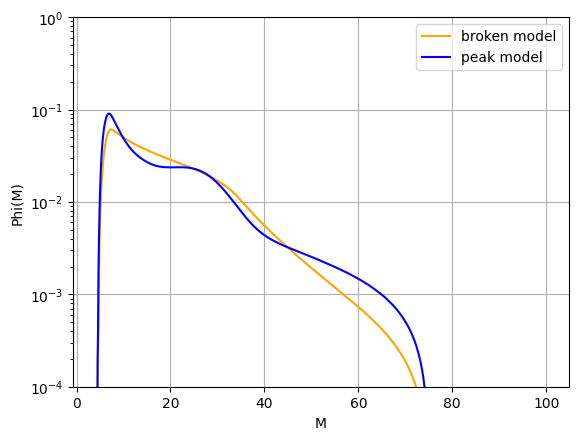

In [ ]:
#Define variables
lamb = 0.10
alph = 2.63
mmin = 4.59
dm = 4.82
mmax = 86.22
mu_m = 33.07
sigm_m = 5.69
beta = 1.26
#Define variables for second model
alpha1 = 1.58
alpha2 = 5.59
mmin2 = 3.96
mmax2 = 87.14
beta2 = 1.40
dm2 = 4.83
b = 0.43

#Calculate phi(M)
npoints = 1000
m_c_list =  np.linspace(4,100,1001)
dmc = m_c_list[1]-m_c_list[0]
phi_m = phi_peak(m_c_list,lamb,alph,beta,mmin,dm,mmax,mu_m,sigm_m,npoints)
phi_m2 = phi_broken(m_c_list,alpha1,alpha2,beta2,mmin,mmax,dm,b,npoints)
#Plot the models
plt.plot(m_c_list,phi_m2,label = 'broken model',color = 'orange')
plt.plot(m_c_list,phi_m,label = 'peak model',color = 'b')
plt.legend()
plt.ylabel('Phi(M)')
plt.xlabel('M')
plt.yscale('log')
plt.ylim(10**-4,1)
plt.grid()

# 2.0 Define ngw prereqs

In [ ]:
def Rgw(z):
  r0 = 23.9 #in Gpc^-3 yr^-1
  rval = r0*(1+z)**(2.7)/(1+((1+z)/(2.9))**(5.6))
  return rval

In [ ]:
def intI(z,Mc,strain): #For Mc
  #cut noise data into pieces
  flist = strain[0:,0]
  farr = np.ones((len(Mc),len(flist)))*flist #make frequency data into 2d array

  noise = strain[0:,1]**2. #square according to dimensions
  narr = np.ones((len(Mc),len(noise)))*noise #copy noise into 2d array

  fmax = 4397/((1+z)*2**(6/5)*Mc) #M = 2^6/5 * Mc
  fmax = fmax[:,np.newaxis]

  ffunc = farr**(-7/3) #calculate the function f^(-7/3)
  psd = narr**(-1) #calculate psd^(-1)
  ffunc[farr>fmax] = 0 #set all values larger than fmax to zero to exclude from integral
  psd[farr>fmax] = 0 #set all values larger than fmax to zero to exclude from integral

  dfarr = np.diff(farr,axis=1) #calculate multidimensional array of df
  #dfarr[dfarr<0] = 0 #get rid off the cutoff jump being large potentially

  summand = ffunc*psd #define the function to integrate over
  res = np.sum((summand[:,1:]+summand[:,:-1])/2*dfarr,axis=1) #trapezoid rule integral (might go wrong at the edges)
  return res

In [ ]:
def intI2(z,m1,q,strain): #For m1 and q
  #cut noise data into pieces
  flist = strain[0:,0]
  farr = np.ones((len(q),len(flist)))*flist #make frequency data into 2d array
  farr3d = np.ones((len(z),len(q),len(flist)))*flist #make frequency into 3d array

  noise = strain[0:,1]**2.#**2 #square according to dimensions
  narr = np.ones((len(q),len(noise)))*noise #copy noise into 2d array
  narr3d = np.ones((len(z),len(q),len(noise)))*narr

  m2 = m1*q
  fp1 = np.ones((len(z),len(m2)))*(1/(m1+m2))
  fp2 = 1/(1+z)
  fp2 = fp2[:,np.newaxis]

  fmax2d = fp1*fp2 #2d fmax array z vertical, m1+m2 horizontally

  ffunc = farr3d**(-7/3) #calculate the function f^(-7/3)
  psd = narr3d**(-1) #calculate psd^(-1)

  ffunc[farr>fmax] = 0 #set all values larger than fmax to zero to exclude from integral
  psd[farr>fmax] = 0 #set all values larger than fmax to zero to exclude from integral

  dfarr = np.diff(farr,axis=1) #calculate multidimensional array of df
  dfarr[dfarr<0] = 0 #get rid off the cutoff jump being large potentially

  summand = ffunc*psd #define the function to integrate over
  res = np.sum((summand[:,:,1:]+summand[:,:,:-1])/2*dfarr)
  res = np.sum((summand[:,1:]+summand[:,:-1])/2*dfarr,axis=1) #trapezoid rule integral (might go wrong at the edges)
  return res

In [ ]:
n1,n2,n3 = (5,3,5)
x = np.ones((n1,n2,n3)) #np.ones((n arrays, rows array, colums arrays))
y = np.ones((n2,n3))*2
z = np.linspace(1,3,3)

q = np.array([1,2,3])
q = q[:,np.newaxis]
print((x*y)**2)
print(y*q)

In [ ]:
def Dlum(z): #works with individual z, not with lists
  c   = 3*10**5. #SOL in natural units? km/s
  H0  = 70*10**(3.)#Hubble constant value in km/s/Gpc
  Ode = 0.714 #Omega DE
  Om  = 0.286 #Omega matter
  part1 = c*(1+z)/H0 #"Prefactor"

  #Numerically solve integral part of Dlum
  zlist = np.linspace(0,z,100)
  dz = zlist[1]-zlist[0]
  Ez = Om*(1+zlist)**3+Ode
  integrand = 1/np.sqrt(Ez)
  part2 = np.sum(integrand*dz)
  tot = part1*part2
  return tot

In [ ]:
def rho0(z,Mc,strain):
  gcf = (1.99*10**30.)**(2./3.)/(3.085*10**(25.)) #conversion of G to Gpc^3 Msol^-1 yr^-2
  gval = 6.67*10**(-11.) #value of G in si units
  cval = 3*10**8. #Value of SOL in m/s
  R = gval/cval**2.
  T = gval/cval**3.
  part1 = np.sqrt(5/(96*np.pi**(4./3.))) #prefactor
  part2 = (((1+z)*Mc)**(5./6.))/Dlum(z)
  part3 = np.sqrt(intI(z,Mc,strain))
  rho0val = gcf*R*(T**(-1./3.))*part1*part2*part3
  return rho0val

In [ ]:
def rho02(z,m1,q,strain):
  gcf = (1.99*10**30.)**(2./3.)/(3.085*10**(25.)) #conversion of G to Gpc^3 Msol^-1 yr^-2
  gval = 6.67*10**(-11.) #value of G in si units
  cval = 3*10**8. #Value of SOL in m/s
  R = gval/cval**2.
  T = gval/cval**3.
  Mc = m1*(q)**(3/5)/(1+q)**(1/5)

  part1 = np.sqrt(5/(96*np.pi**(4/3))) #prefactor
  part2 = (1+z)**(5/6)/Dlum(z) #z dependance part
  part2 = np.ones((len(z),len(q)))*part2 #array with z dependance vertically
  part31 = Mc**(5/6) # m1,q dependance part 1
  part32 = np.sqrt(intI2(z,m1,q,strain)) #2d array with m1,q horizontal, z vertical
  comb = part2*part31*part31*part1 #combining everything into 2d array

  rho0val = gcf*R*(T**(-1./3.))*comb #Applying coordinate correction

  return rho0val

In [ ]:
x = np.ones((8,10))
print(x)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


Text(0, 0.5, 'Theta')

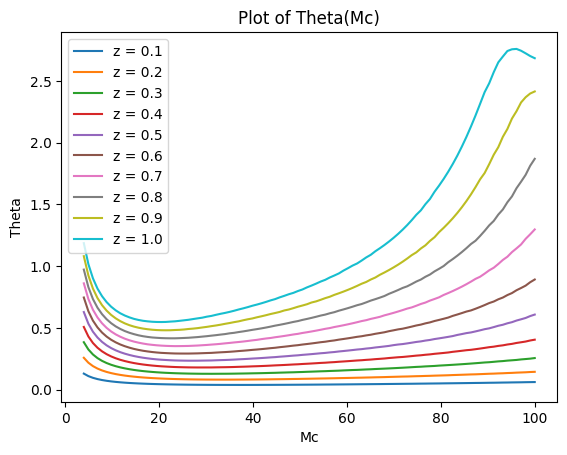

In [ ]:
zlist = np.linspace(0.1,1,10)
Mclist = np.linspace(4,100,100)
strain = np.loadtxt('https://dcc.ligo.org/public/0149/T1800044/005/aLIGODesign.txt')
for zval in zlist:
  r0 = rho0(zval,Mclist,strain)
  theta = 5/r0
  plt.plot(Mclist,theta,label = 'z = %s'%(round(zval,1)))

plt.legend(loc= 'upper left')
plt.title('Plot of Theta(Mc)')
plt.xlabel('Mc')
plt.ylabel('Theta')

(0.0, 250.0)

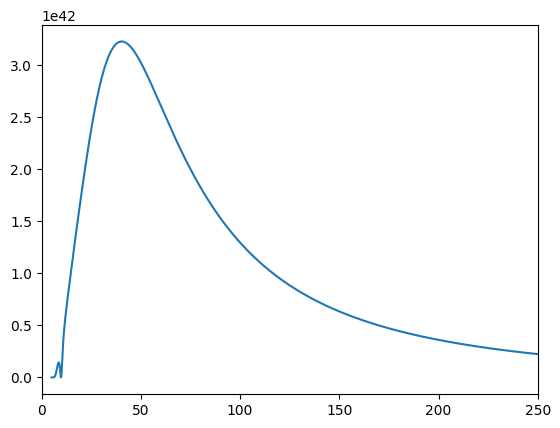

In [ ]:
strain = np.loadtxt('https://dcc.ligo.org/public/0149/T1800044/005/aLIGODesign.txt')
x = strain[:,0]
y = strain[:,1]**2
plt.plot(x,x**(-7/3)*y**(-1))
plt.xlim(0,250)
#plt.xscale('log')

In [ ]:
def dMdq(m1,q):
  res = m1/(5*(1+q)**(1/5))*(3+2*q)/(q**(2/5)*(1+q))
  return res

#2.1.1 Define ngw_peak m1/q

In [ ]:
def ngw_peak_o(z,strain,rth):
  #Peak model constants
  lamb = 0.10
  alph = 2.63
  mmin = 4.59
  dm = 4.82
  mmax = 86.22
  mu_m = 33.07
  sigm_m = 5.69
  beta = 1.26
  tau = 1
  pf = tau*Rgw(z)/(1+z) #prefactor term
  #double integral
  m1list = np.linspace(mmin+0.1,150,len(z))
  dm1 = m1list[1]-m1list[0]
  qlist = np.linspace(0.01,0.99,len(z))
  dq = qlist[1]-qlist[0]
  qint = []
  for m1 in m1list: #integral over q for each m1
    mclist = m1*(qlist)**(3/5)/(1+qlist)**(1/5) #mc for m1 with qlist
    f = f_pdf(qlist,m1,beta,mmin,dm)/norm_secondary_peak_pdf(m1) #f(q|m1), need to figure out normalisation
    t = 1 - calc_int_pdf(rth/rho02(z,m1,qlist,strain)) # T(4) - T(theta(m1,q)), calc_int_pdf(4) = T(4) = 1
    j = dMdq(m1,qlist)/m1*dx1dm_calc(m1,mclist)[1] #Jacobian term
    int1 = f*t*j
    res1 = np.sum((int1[:,1:]+int1[:,:-1])/2*dq,axis=1) #sum over q, result is array in z values
    qint.append(res1)
  qint = np.array(qint)
  qint = np.transpose(qint) #transpose qint array to get z vertical and m1 horizontal
  #print(np.shape(qint))
  gnorm = g_pdf_peak_norm(m1norm,lamb,alph,mmin,dm,mmax,mu_m,sigm_m) #Normalisation for g(m1)
  g = gnorm[2]*g_pdf_peak(m1list,lamb,alph,mmin,dm,mmax,mu_m,sigm_m,gnorm[0],gnorm[1]) #calculate g(m1)
  int2 = g*qint #integrand for m1 integral
  res2 = np.sum((int2[:,1:]+int2[:,:-1])/2*dm1,axis=1) #integrate over m1, returns array in z
  res3 = pf*res2
  return res3

# Define ngw_peak Mc/m1

In [ ]:
def ngw_peak(zlist,strain,rth):
  #Peak model constants
  lamb = 0.10
  alph = 2.63
  mmin = 4.59
  dm = 4.82
  mmax = 86.22
  mu_m = 33.07
  sigm_m = 5.69
  beta = 1.26
  tau = 1
  npts = 1000
  #prefactor term
  pf = tau*Rgw(zlist)/(1+zlist)

  mclist = np.linspace(4,99,len(zlist))
  dmc = np.diff(mclist)
  phi = phi_peak(mclist,lamb,alph,beta,mmin,dm,mmax,mu_m,sigm_m,npts) #calculate phi(M)
  res = []
  for z in zlist:
    r0 = rho0(z,mclist,strain) #calculate rho0
    theta = rth/r0 #calculate theta for rho0
    s = 1 - calc_int_pdf(theta) #S(theta) = T(4) - T(theta) = 1 - T(theta)
    f = phi*s
    res.append(f)
  res = np.array(res)
  out = np.sum((res[:,:1]+res[:,:-1])/2*dmc,axis=1)
  out = pf*out
  return out

#2.1.2 Define ngw_broken

In [ ]:
def ngw_broken(z,alpha1,alpha2,mmin2,mmax2,dm2,b,strain,rth):
  tau = 1
  pf = tau*Rgw(z)/(1+z) #prefactor term
  #double integral
  m1list = np.linspace(mmin+0.1,150,100)
  dm1 = m1list[1]-m1list[0]
  qlist = np.linspace(0.01,0.99,100)
  dq = qlist[1]-qlist[0]
  qint = []
  for m1 in m1list: #integral over q for each m1
    mclist = m1*(qlist)**(3/5)/(1+qlist)**(1/5) #mc for m1 with qlist
    f = f_pdf(qlist,m1,beta,mmin,dm)/norm_secondary_peak_pdf(m1) #f(q|m1), need to figure out normalisation
    t = calc_int_pdf(4) - calc_int_pdf(rth/rho0(z,m1,qlist,mclist,strain)) # T(4) - T(theta(m1,q))
    j = dMdq(m1,qlist)/m1*dx1dm_calc(m1,mclist)[1] #Jacobian term
    int1 = f*t*j
    res1 = np.sum((int1[1:]+int1[:-1])/2*dq)
    qint.append(res1)
  qint = np.array(qint)
  gnorm = g_pdf_broken_norm(m1norm,alpha1,alpha2,mmin2,mmax2,dm2,b) #Normalisation for g(m1)
  g = gnorm*g_pdf_broken(m1list,alpha1,alpha2,mmin2,mmax2,dm2,b) #calculate g(m1)
  int2 = g*qint
  res2 = np.sum((int2[1:]+int2[:-1])/2*dm1)
  return res2


# Define ngw_broken (new)

In [ ]:
def ngw_broken(zlist,strain,rth):
  #Broken model constants
  alpha1 = 1.58
  alpha2 = 5.59
  mmin2 = 3.96
  mmax2 = 87.14
  beta2 = 1.40
  dm2 = 4.83
  b = 0.43
  tau = 1
  npoints = 1000

  pf = tau*Rgw(zlist)/(1+zlist) #prefactor term

  mclist = np.linspace(4,99,len(zlist))
  dmc = np.diff(mclist)
  phi = phi_broken(mclist,alpha1,alpha2,beta2,mmin,mmax,dm,b,npoints)
  res = []
  for z in zlist:
    r0 = rho0(z,mclist,strain) #calculate rho0
    theta = rth/r0 #calculate theta for rho0
    s = 1 - calc_int_pdf(theta) #S(theta) = T(4) - T(theta) = 1 - T(theta)
    f = phi*s
    res.append(f)
  res = np.array(res*pf)
  out = np.sum((res[:,:1]+res[:,:-1])/2*dmc,axis=1)
  return out


# Test ngw (new version)

<ipython-input-3-3ca3784daf5b>:3: RuntimeWarning: overflow encountered in exp
  f = np.exp(deltam/m + deltam/(m-deltam))


(0.5, 1000.0)

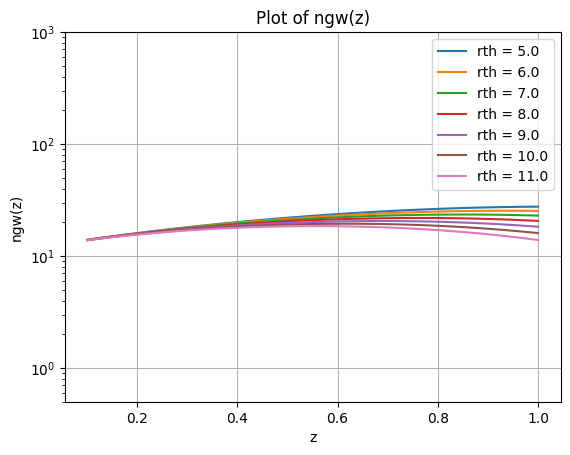

In [ ]:
strain = np.loadtxt('https://dcc.ligo.org/public/0149/T1800044/005/aLIGODesign.txt')
rthlist = np.linspace(5,11,7)
#rth = 5
zlist = np.linspace(0.1,1,101)
#ngwp = ngw_peak(zlist,strain,rth)
#ngwp2 = ngw_peak_o(zlist,strain,rth)
#ngwb = ngw_broken(zlist,strain,rth)

#plt.plot(zlist,ngwp)
#plt.grid()
#plt.yscale('log')

for rth in rthlist:
  ngwp = ngw_peak(zlist,strain,rth)
  plt.plot(zlist,ngwp,label = 'rth = %s'%(rth))
#plt.plot(zlist,ngwp,label='Mc',color='r',alpha=0.6)
#plt.plot(zlist,ngwp2,label='m1/q',color='b',alpha=0.6)
plt.legend()
plt.grid()
plt.title('Plot of ngw(z)')
plt.yscale('log')
plt.xlabel('z')
plt.ylabel('ngw(z)')
plt.ylim(5*10**(-1.),10**3.)


# 2.1 Plot and look at strain

Text(0, 0.5, 'Strain')

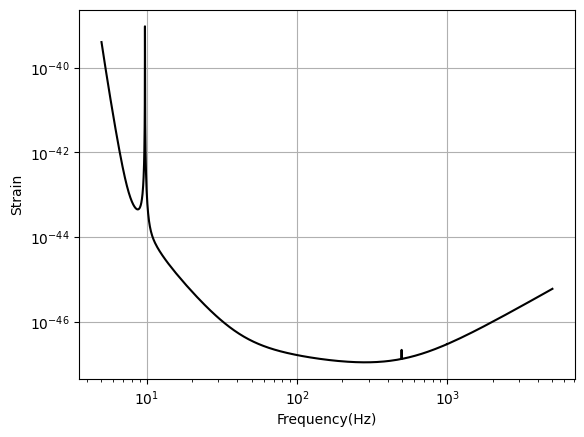

In [ ]:
test = np.loadtxt('https://dcc.ligo.org/public/0149/T1800044/005/aLIGODesign.txt') #Load the data from LIGO
plt.plot(test[0:,0],test[0:,1]**2, c ='black') #Plot the LIGO data
plt.grid()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Frequency(Hz)') #plotted from 5 to 5000
plt.ylabel('Strain')
#plt.ylim(4*10**(-25),9*10**(-22))

# 2.2 Define S_gw for both models

In [ ]:
def Sgw_peak(zlist,rhoth,strain):
  #model constants
  lamb = 0.10
  alph = 2.63
  mmin = 4.59
  dm = 4.82
  mmax = 86.22
  mu_m = 33.07
  sigm_m = 5.69
  beta = 1.26
  npts = 1000
  pf = rhoth/5

  mclist = np.linspace(4,99,len(zlist))
  dmc = np.diff(mclist)
  phi = phi = phi_peak(mclist,lamb,alph,beta,mmin,dm,mmax,mu_m,sigm_m,npts) #calculate phi(M)

  uparr = []
  loarr = []
  for z in zlist:
    r0 = rho0(z,mclist,strain)
    theta = rhoth/r0
    up = P_pdf(theta)/r0
    uparr.append(up)
    lo = (1 - calc_int_pdf(theta))
    loarr.append(lo)

  uparr = np.array(uparr)
  loarr = np.array(loarr)
  uparr = phi*uparr
  loarr = phi*loarr
  upint = np.sum((uparr[:,:-1]+uparr[:,1:])/2*dmc)
  loint = np.sum((loarr[:,:-1]+loarr[:,1:])/2*dmc)
  res = pf*upint/loint

  return res

def Sgw_broken(zlist,rhoth,strain):
  alpha1 = 1.58
  alpha2 = 5.59
  mmin2 = 3.96
  mmax2 = 87.14
  beta2 = 1.40
  dm2 = 4.83
  b = 0.43
  npoints = 1000
  pf = rhoth/5

  mclist = np.linspace(4,99,len(zlist))
  dmc = np.diff(mclist)
  phi = phi_broken(mclist,alpha1,alpha2,beta2,mmin,mmax,dm,b,npoints)

  uparr = []
  loarr = []
  for z in zlist:
    r0 = rho0(z,mclist,strain)
    theta = rhoth/r0
    up = P_pdf(theta)/r0
    uparr.append(up)
    lo = (1 - calc_int_pdf(theta))
    loarr.append(lo)

  uparr = np.array(uparr)
  loarr = np.array(loarr)
  uparr = phi*uparr
  loarr = phi*loarr
  upint = np.sum((uparr[:,:-1]+uparr[:,1:])/2*dmc)
  loint = np.sum((loarr[:,:-1]+loarr[:,1:])/2*dmc)
  res = pf*upint/loint
  return res


# 2.3 Plot S_gw